In [1]:
import sys
import numpy as np
import progressbar
import os
import subprocess
import wrapper_pkg
import json
import matplotlib.pyplot as plt
import shutil

path = "perf_short"

Found translator module:  <module 'ops_translator.c.ops' from '/opt/conda/lib/python3.6/site-packages/ops_translator/c/ops.py'>


/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
shutil.rmtree(path, ignore_errors=True)
os.mkdir(path)

script = """
import sys
sys.path.append('..')
import wrapper_pkg
import json

sim_class = {sim_class}
num_steps = {num_steps}
grid_dims = {grid_dims}
grid_params = wrapper_pkg.DimParams(n=grid_dims, d=1e-9)
time_params = wrapper_pkg.DimParams(d=1e-14, n=num_steps)
sim_params = wrapper_pkg.SimParams(A=1e-11,
                             K=0.1e3,
                             D=0,
                             Hmag=0.1e3,
                             Ms=8e5,
                             e=[1,0,0],
                             Hdir=[0,0,1],
                             alpha=0.8)
sim = sim_class(sim_params, grid_params, time_params, save_every=num_steps, periodic_boundary=True, print_params=False)
sim.init_vortex()
complete, time = sim.run()
file = open("performance_result.data", "w")
json.dump({{"complete":complete, "time":time}}, file)
file.close()
"""
    
class_list = {'wrapper_pkg.OommfSim':['OOMMF_THREADS'], 
                'wrapper_pkg.DevitoSim':['OMP_NUM_THREADS'],
                'wrapper_pkg.OpenSbliSim':['OMP_NUM_THREADS']}
                #'wrapper_pkg.NumpySim':['OMP_NUM_THREADS','NUMEXPR_NUM_THREADS','MKL_NUM_THREADS']}
steps_list = [1,1000]
grid_list = [(5, 5, 5), (250, 250, 5)]
thread_list = [0] + [2**i for i in range(4)]

results = []

average_over_runs = 3
list_lengths = (len(class_list), len(steps_list), len(grid_list), len(thread_list))
setups = np.ndindex(*list_lengths)
bar = progressbar.ProgressBar(max_value=average_over_runs * np.prod(list_lengths))
run_index = 0
bar.update(run_index)

starting_env = os.environ.copy()
for setup in setups:    
    os.environ = starting_env.copy()
    
    num_steps = steps_list[setup[1]]
    grid_dims = grid_list[setup[2]]
    num_threads = thread_list[setup[3]]    
    sim_class = list(class_list)[setup[0]]    
    envs = class_list[sim_class]
  
    result = {"framework":eval(sim_class).framework_name, 
              "num_steps":num_steps, 
              'grid_dims':grid_dims, 
              'num_threads':num_threads}
    print("\n\nRunning:", result, file=sys.stderr)
            
    if num_threads != 0:
        os.environ['OMP_PROC_BIND'] = "1"
        os.environ['OMP_NUM_PROCS'] = "1"
        for e in envs:
            print(e, str(num_threads), file=sys.stderr)
            os.environ[e] = str(num_threads)
    
    file = open("{}/performance.py".format(path), "w")
    file.write(script.format(sim_class=sim_class, num_steps=num_steps, grid_dims=grid_dims))
    file.close()
    
    total_time = 0
    completed_runs = 0
    for i in range(average_over_runs):
        proc = subprocess.Popen(["python","performance.py".format(path)], stdout=subprocess.PIPE, stderr=subprocess.PIPE, 
                                cwd=path, env=os.environ)
        stdout, stderr = proc.communicate()
        if proc.returncode != 0:
            print(stdout.decode('utf-8'), file=sys.stderr)
            print(stderr.decode('utf-8'), file=sys.stderr)
                
        file = open("{}/performance_result.data".format(path), "r")
        perf_result = json.load(file)
        file.close()
        
        complete = perf_result['complete']
        time = perf_result['time']
        if complete:
            print("Complete:", time, file=sys.stderr)
            total_time += time
            completed_runs +=1
        else:
            print("Failed:", file=sys.stderr)
            print(stdout.decode('utf-8'), file=sys.stderr)
            print(stderr.decode('utf-8'), file=sys.stderr)
        run_index += 1
        
    result["time"] = total_time / completed_runs if completed_runs > 0 else -1
    results.append(result)
    bar.update(run_index)

file = open("{}/num_thread_performance.data".format(path), "w")
json.dump(results, file)
file.close()

N/A% (0 of 180) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Running: {'framework': 'OOMMF', 'num_steps': 1, 'grid_dims': (5, 5, 5), 'num_threads': 0}
Complete: 0.19754648208618164
Complete: 0.1931469440460205
Complete: 0.20326805114746094
  1% (3 of 180) |                          | Elapsed Time: 0:00:04 ETA: 0:04:09

Running: {'framework': 'OOMMF', 'num_steps': 1, 'grid_dims': (5, 5, 5), 'num_threads': 1}
OOMMF_THREADS 1
Complete: 0.20879411697387695
Complete: 0.19717764854431152
Complete: 0.19440889358520508
  3% (6 of 180) |                          | Elapsed Time: 0:00:08 ETA: 0:04:04

Running: {'framework': 'OOMMF', 'num_steps': 1, 'grid_dims': (5, 5, 5), 'num_threads': 2}
OOMMF_THREADS 2
Complete: 0.19555282592773438
Complete: 0.19467592239379883
Complete: 0.19238734245300293
  5% (9 of 180) |#                         | Elapsed Time: 0:00:12 ETA: 0:03:59

Running: {'framework': 'OOMMF', 'num_steps': 1, 'grid_dims': (5, 5, 5), 'num_threads': 4}
OOMMF_THREADS 4

Complete: 0.01041865348815918
Complete: 0.010417938232421875
Complete: 0.010426998138427734
 50% (90 of 180) |############             | Elapsed Time: 0:17:47 ETA: 0:30:21

Running: {'framework': 'Devito', 'num_steps': 1000, 'grid_dims': (5, 5, 5), 'num_threads': 0}
Complete: 0.05550408363342285
Complete: 0.06826663017272949
Complete: 0.09019255638122559
 51% (93 of 180) |############             | Elapsed Time: 0:18:46 ETA: 0:29:20

Running: {'framework': 'Devito', 'num_steps': 1000, 'grid_dims': (5, 5, 5), 'num_threads': 1}
OMP_NUM_THREADS 1
Complete: 0.011257648468017578
Complete: 0.011224508285522461
Complete: 0.011281728744506836
 53% (96 of 180) |#############            | Elapsed Time: 0:19:44 ETA: 0:28:22

Running: {'framework': 'Devito', 'num_steps': 1000, 'grid_dims': (5, 5, 5), 'num_threads': 2}
OMP_NUM_THREADS 2
Complete: 0.008943557739257812
Complete: 0.009013175964355469
Complete: 0.00872802734375
 55% (99 of 180) |#############            | Elapsed Time: 0:20:43 ETA: 0:2

Complete: 78.46621346473694
 98% (177 of 180) |####################### | Elapsed Time: 0:55:01 ETA: 0:02:35

Running: {'framework': 'OpenSBLI', 'num_steps': 1000, 'grid_dims': (250, 250, 5), 'num_threads': 8}
OMP_NUM_THREADS 8
Complete: 56.899282932281494
Complete: 56.80515694618225
Complete: 55.96555709838867
100% (180 of 180) |#######################| Elapsed Time: 0:58:03 ETA:  0:00:00

perf_short/num_thread_perf_s1000_g[5_5_5].png


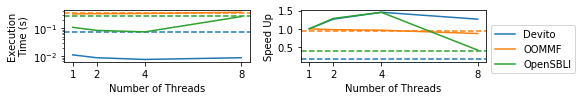

perf_short/num_thread_perf_s1000_g[250_250_5].png


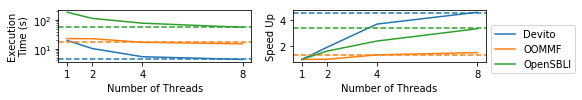

perf_short/num_thread_perf_s1_g[5_5_5].png


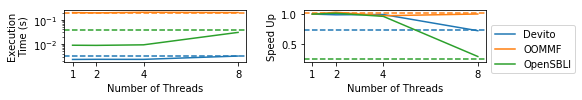

perf_short/num_thread_perf_s1_g[250_250_5].png


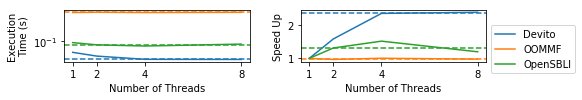

In [3]:
file = open("{}/num_thread_performance.data".format(path), "r")
results = json.load(file)
file.close()

class_list = {'wrapper_pkg.OommfSim':['OOMMF_THREADS'], 
                'wrapper_pkg.DevitoSim':['OMP_NUM_THREADS'],
                'wrapper_pkg.OpenSbliSim':['OMP_NUM_THREADS']}
                #'wrapper_pkg.NumpySim':['OMP_NUM_THREADS','NUMEXPR_NUM_THREADS','MKL_NUM_THREADS']}
steps_set = [1,1000]
grid_list = [(5, 5, 5), (250, 250, 5)]
thread_list = [0] + [2**i for i in range(4)]

frameworks = set()
steps_set = set()
grid_set = set()
thread_set = set()
for r in results:
    frameworks.add(r['framework'])
    steps_set.add(r['num_steps'])
    grid_set.add(str(r['grid_dims']))
    thread_set.add(r['num_threads'])
steps_list = list(steps_set)
grid_list = list(grid_set)
thread_list = sorted(list(thread_set))
frameworks_list = sorted(list(frameworks))

for num_steps in steps_list:
    for grid_dims in grid_list:
        fig, ax = plt.subplots(1, 2, figsize=(7,1.5))

        for c in frameworks_list:
            r_sub = [r for r in results if r['framework'] == c
                     and r['num_steps'] == num_steps
                     and str(r['grid_dims']) == grid_dims]
            if len(r_sub) > 0:
                times = np.array([r['time'] for r in r_sub])
                n_threads = [r['num_threads'] for r in r_sub]
                p = ax[1].plot(n_threads[1:], times[1] / times[1:], label=c)
                ax[1].axhline(times[1] / times[0], ls='--', c=p[0].get_c())
                p = ax[0].semilogy(n_threads[1:], times[1:], label=c)
                ax[0].axhline(times[0], ls='--', c=p[0].get_c())    

        ax[1].set(xlabel=r"Number of Threads", ylabel=r"Speed Up")
        ax[1].get_xaxis().set_ticks(thread_list[1:])        
        ax[0].set(xlabel=r"Number of Threads", ylabel=r"Execution" "\n" "Time (s)")
        ax[0].get_xaxis().set_ticks(thread_list[1:])
        ax[1].legend(bbox_to_anchor=(1, 0.8))
        fig.tight_layout()
        filename = '{}/num_thread_perf_s{}_g{}.png'.format(path, num_steps, grid_dims).replace(",", "").replace(" ", "_")
        print(filename)
        plt.savefig(filename, bbox_inches='tight', dpi=400)
        plt.show()